In [1]:
import kaggle

In [2]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
import timm
from fastai.vision.all import *
from fastai.imports import *

# Creating dataloader

In [4]:
arch = "resnet18"
path = Path('/nfs/home/912c2e22633dde2e/RSNA-Screening-Mammography-Patch-Heatmap-Classifier/patches_dst/ratio0.5_patches10_256x')
files = get_image_files(path)

set_seed(123)

In [5]:
ptidx_unique = np.unique(np.array([str(x).split("/")[-2] for x in files]))
valid = np.random.choice(ptidx_unique, size=int(len(ptidx_unique)*0.15), replace=False)

splitter = FuncSplitter(lambda o: str(o).split(os.path.sep)[-2] in valid)

aug_transforms = [Dihedral(p=1.0), Contrast(0.1), Brightness(0.1), Zoom(), Warp(magnitude=0.1)]

cbs = [EarlyStoppingCallback(min_delta=0.001, patience=4)]

loss_func = LabelSmoothingCrossEntropy()
metrics = [error_rate, RocAuc()]

In [6]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=splitter,
                 get_y=using_attr(RegexLabeller(r'([A-Z]+)'), 'name'),
                 batch_tfms=[*aug_transforms, Normalize.from_stats(*imagenet_stats)],
               ).dataloaders(path, bs=64, shuffle=True)

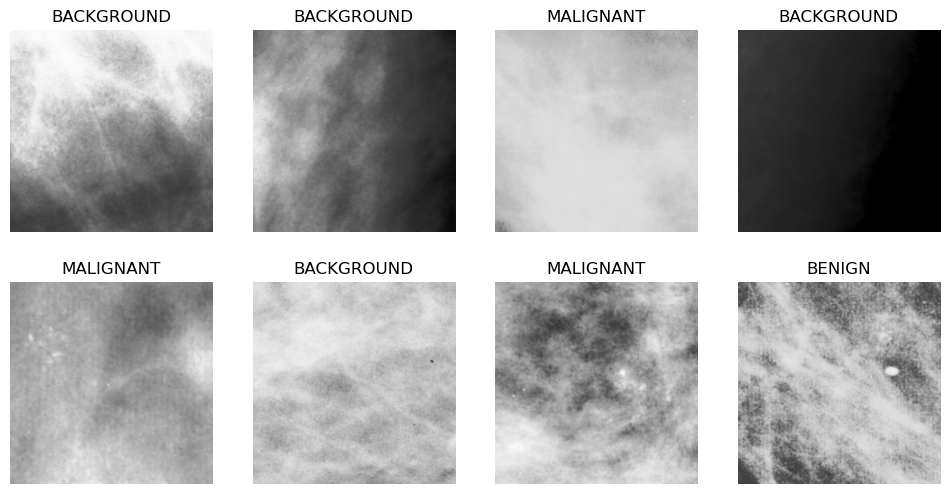

In [7]:
dls.show_batch(max_n=8)

# One cycle

In [8]:
learn = vision_learner(dls, arch, metrics=metrics, loss_func=loss_func).to_fp16()

SuggestedLRs(valley=0.0030199517495930195)

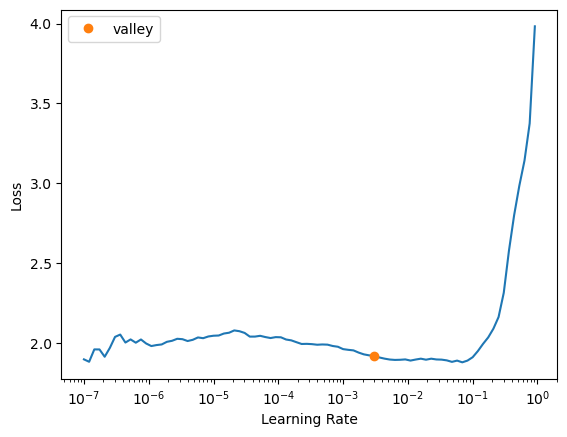

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(100, slice(1e-2), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="one_cycle_1")])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,1.360164,1.074504,0.503108,0.691865,00:41
1,1.141807,1.001442,0.479708,0.712649,00:41
2,1.028360,0.996171,0.490676,0.704374,00:40
3,0.994761,0.993317,0.486289,0.713855,00:41
4,0.983378,0.991041,0.476782,0.720208,00:40
5,0.967534,0.967794,0.461792,0.732130,00:41
6,0.956935,0.965987,0.459963,0.737927,00:41
7,0.948849,0.976871,0.441316,0.742943,00:41
8,0.949774,0.944755,0.423035,0.759851,00:41
9,0.934507,0.932297,0.415722,0.764964,00:41


Better model found at epoch 0 with valid_loss value: 1.0745035409927368.
Better model found at epoch 1 with valid_loss value: 1.0014415979385376.
Better model found at epoch 2 with valid_loss value: 0.9961705803871155.
Better model found at epoch 3 with valid_loss value: 0.9933168888092041.
Better model found at epoch 4 with valid_loss value: 0.9910407066345215.
Better model found at epoch 5 with valid_loss value: 0.9677944779396057.
Better model found at epoch 6 with valid_loss value: 0.9659867286682129.
Better model found at epoch 8 with valid_loss value: 0.9447546005249023.
Better model found at epoch 9 with valid_loss value: 0.9322965741157532.
Better model found at epoch 11 with valid_loss value: 0.9184094667434692.
Better model found at epoch 12 with valid_loss value: 0.9087054133415222.
Better model found at epoch 13 with valid_loss value: 0.8852207660675049.
Better model found at epoch 16 with valid_loss value: 0.8805322051048279.
No improvement since epoch 16: early stopping


In [11]:
learn.load("one_cycle_1")
learn.unfreeze()

learn.fit_one_cycle(100, slice(2.5e-5, 2.5e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="one_cycle_2")])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.803630,0.867354,0.363803,0.814375,00:50
1,0.792902,0.867471,0.360878,0.815292,00:51
2,0.791138,0.862487,0.359049,0.818547,00:50
3,0.795039,0.870908,0.362340,0.815931,00:50
4,0.783970,0.862287,0.358318,0.819125,00:50
5,0.773313,0.868585,0.358684,0.821494,00:50
6,0.767076,0.863766,0.360512,0.821860,00:50


Better model found at epoch 0 with valid_loss value: 0.867353618144989.
Better model found at epoch 2 with valid_loss value: 0.8624869585037231.
Better model found at epoch 4 with valid_loss value: 0.8622865676879883.
No improvement since epoch 2: early stopping


# Ranger, Mish, Flat cos, xresnet

In [12]:
arch = xresnet18(pretrained=True, act_cls=Mish, sa=True, n_out=3)

In [13]:
learn = Learner(dls, model=arch, metrics=metrics, loss_func=loss_func, opt_func=ranger).to_fp16()

SuggestedLRs(valley=0.0003311311302240938)

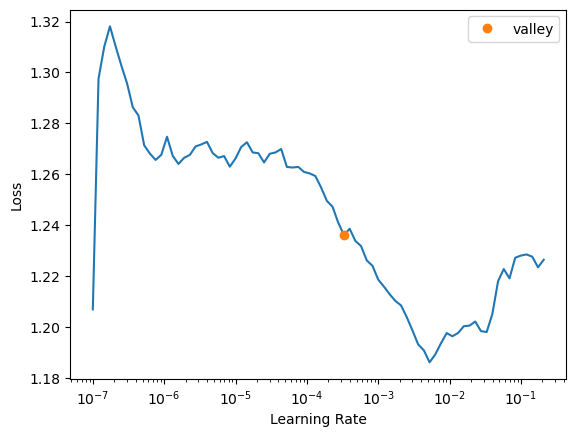

In [14]:
learn.lr_find()

In [15]:
learn.fit_flat_cos(100, slice(5e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="xresnet_ranger_flatcos_1")])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,1.025856,1.254710,0.559781,0.612833,01:08
1,1.008617,1.051692,0.547715,0.653549,01:08
2,0.987040,0.988841,0.500548,0.706789,01:07
3,0.969252,0.967625,0.468373,0.727392,01:08
4,0.946049,0.945159,0.471664,0.748973,01:08
5,0.914402,0.932683,0.450823,0.759664,01:08
6,0.907233,1.072313,0.500183,0.702479,01:07
7,0.896117,0.899837,0.446069,0.768749,01:08
8,0.876639,1.631762,0.485558,0.705172,01:07
9,0.869889,0.934929,0.444241,0.757119,01:08


Better model found at epoch 0 with valid_loss value: 1.25471031665802.
Better model found at epoch 1 with valid_loss value: 1.0516924858093262.
Better model found at epoch 2 with valid_loss value: 0.9888405203819275.
Better model found at epoch 3 with valid_loss value: 0.9676249623298645.
Better model found at epoch 4 with valid_loss value: 0.9451588988304138.
Better model found at epoch 5 with valid_loss value: 0.9326825141906738.
Better model found at epoch 7 with valid_loss value: 0.8998366594314575.
No improvement since epoch 7: early stopping


In [16]:
learn.load("xresnet_ranger_flatcos_1")
learn.unfreeze()

learn.fit_flat_cos(100, slice(1e-5, 1e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="xresnet_ranger_flatcos_2")])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.862525,0.877761,0.427788,0.784307,01:08
1,0.849306,0.875934,0.418647,0.787567,01:07
2,0.847391,0.874982,0.426691,0.789599,01:08
3,0.837797,0.884327,0.416819,0.787010,01:07
4,0.836990,0.884185,0.420110,0.786215,01:08
5,0.828714,0.890708,0.406947,0.786990,01:08


Better model found at epoch 0 with valid_loss value: 0.8777605295181274.
Better model found at epoch 1 with valid_loss value: 0.8759341835975647.
Better model found at epoch 2 with valid_loss value: 0.874981701374054.
No improvement since epoch 1: early stopping


# Reduce lr on plateau

In [17]:
arch = "resnet18"

In [18]:
learn = vision_learner(dls, arch, metrics=metrics, loss_func=loss_func).to_fp16()

In [19]:
learn.fit(100, slice(1e-2), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="redlrplat_1"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-6)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,1.125808,1.025890,0.485192,0.714794,00:42
1,0.975640,0.949949,0.448629,0.746000,00:42
2,0.920382,0.924595,0.425229,0.781124,00:41
3,0.873555,0.877360,0.382084,0.801713,00:41
4,0.868580,0.887949,0.387934,0.797402,00:41
5,0.843357,0.875742,0.374040,0.807671,00:41
6,0.819101,0.862132,0.368556,0.814845,00:41
7,0.809101,0.865297,0.368921,0.815135,00:41
8,0.805369,0.865561,0.367824,0.815743,00:41
9,0.810587,0.865655,0.364899,0.815104,00:41


Better model found at epoch 0 with valid_loss value: 1.0258901119232178.
Better model found at epoch 1 with valid_loss value: 0.9499490261077881.
Better model found at epoch 2 with valid_loss value: 0.9245951771736145.
Better model found at epoch 3 with valid_loss value: 0.8773597478866577.
Better model found at epoch 5 with valid_loss value: 0.8757423162460327.
Epoch 5: reducing lr to 0.001
Better model found at epoch 6 with valid_loss value: 0.8621323108673096.
Epoch 8: reducing lr to 0.0001
Epoch 10: reducing lr to 1e-05
No improvement since epoch 6: early stopping


In [20]:
learn.load("redlrplat_1")
learn.unfreeze()

learn.fit(100, slice(2.5e-5, 2.5e-3), cbs=[*cbs, SaveModelCallback(with_opt=True, fname="redlrplat_2"), ReduceLROnPlateau(min_delta=0.01, patience=2, min_lr=1e-8)])

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.801488,0.853865,0.367824,0.820267,00:50
1,0.785210,0.863134,0.367459,0.819770,00:49
2,0.755967,0.850531,0.352834,0.828261,00:50
3,0.723794,0.850473,0.341499,0.831352,00:50
4,0.709430,0.867102,0.347715,0.829184,00:50
5,0.720551,0.864458,0.344790,0.829576,00:50
6,0.722164,0.863439,0.346984,0.830486,00:50


Better model found at epoch 0 with valid_loss value: 0.8538647294044495.
Better model found at epoch 2 with valid_loss value: 0.850531280040741.
Epoch 2: reducing lr to 0.00025
Better model found at epoch 3 with valid_loss value: 0.8504729270935059.
Epoch 4: reducing lr to 2.5e-05
Epoch 6: reducing lr to 2.5e-06
No improvement since epoch 2: early stopping
